In [1]:
# Import Statements

%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib

#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

/home/mtezcan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 - Load Data

Before running the code, the data should be downloaded and foldered in the way that is usable for imagefolder function of the PyTorch. The following code assumes that the main directory for the dataset is 'data_dir' and it includes subdirectories for all of the separate classes.

For details on how to create those folders, pleaserefer to 'dataset/Folder_images.ipynb'

In [3]:
indices

[137695,
 432335,
 303892,
 139447,
 249590,
 108981,
 170788,
 340813,
 324588,
 67214,
 55697,
 32095,
 161633,
 363814,
 43454,
 259535,
 266540,
 310707,
 250130,
 435332,
 204099,
 183758,
 182794,
 3632,
 265540,
 182282,
 36228,
 133477,
 164934,
 120326,
 341723,
 75414,
 26740,
 224508,
 314925,
 284773,
 94898,
 48024,
 266418,
 39972,
 197880,
 265401,
 209345,
 152633,
 124745,
 26095,
 348602,
 368600,
 303475,
 232710,
 310264,
 42458,
 3202,
 61196,
 15026,
 385590,
 253483,
 109738,
 423847,
 377605,
 167846,
 25070,
 330615,
 108342,
 208791,
 185750,
 143979,
 43068,
 130873,
 210903,
 264279,
 198989,
 349000,
 196058,
 330740,
 56881,
 328857,
 403724,
 309643,
 299928,
 365881,
 239247,
 35312,
 344372,
 297965,
 88022,
 309224,
 429369,
 176110,
 49935,
 285616,
 411439,
 217323,
 237864,
 334597,
 11307,
 112818,
 125830,
 372982,
 377327,
 408864,
 79102,
 248019,
 113340,
 346201,
 343469,
 305435,
 334100,
 346407,
 168971,
 410898,
 240342,
 122169,
 195614,


In [2]:
'''
Macros
'''
#uniform_sampler=False
batch_size=32
nclasses=10 #Number of output classes
split=200
random_seed=1
shuffle=True
dataset = 'Amazon'
CV = 0
train_val = (100000, 10000)

# Data augmentation and normalization for training 
# Just normalization for validation
'''data_transforms = {
    'train': transforms.Compose([
        #transforms.Scale(64),
        transforms.RandomCrop(56),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        #transforms.Scale(64),
        transforms.CenterCrop(56),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}'''

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


'''Create ImageFolder objects for training and test'''

if dataset == 'Hoarding':
    data_dir = '/media/mtezcan/New Volume/Extreme Picture Finder/all images'
else:
    data_dir = '../images'  
    

if not CV == 0:  
    dset_train = datasets.ImageFolder(data_dir+'/train_val', data_transforms['train'])
    dset_val = datasets.ImageFolder(data_dir+'/train_val', data_transforms['val'])
    
    num_train = len(dset_train)
    indices = list(range(num_train))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
    splits = (num_train*np.linspace(0,1,CV+1)).astype(int)
    
    val_idx = [indices[splits[k]:splits[k+1]] for k in range(CV)]
    train_idx=[np.setdiff1d(indices,val_idx[k]) for k in range(CV)]
    '''Sampler functions for validation and training'''
    sampler_train = [torch.utils.data.sampler.SubsetRandomSampler(train_idx[k]) for k in range(CV)]
    sampler_val = [torch.utils.data.sampler.SubsetRandomSampler(val_idx[k]) for k in range(CV)]

    '''Define dataset loaders'''
    dset_loaders_arr = [{'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train[k],
                                                        num_workers=12),
                    'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val[k],
                                                        num_workers=12)} for k in range(CV)]
    dset_sizes={'train':int(len(dset_train)*(1-1/CV)),'val':int(len(dset_train)*(1/CV))}
    
    print(dset_sizes)
    print('OR')
    print('Number of training images '+str(len(val_idx)))
    print('Number of validation images '+str(len(train_idx)))

elif train_val:
    
    dset_train = datasets.ImageFolder(data_dir+'/train/0to5', data_transforms['train'])
    dset_val = datasets.ImageFolder(data_dir+'/train/0to5', data_transforms['val'])
    
    num_train = len(dset_train)
    indices = list(range(num_train))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
    train_idx = indices[:train_val[0]]
    val_idx = indices[-train_val[1]:]
    '''Sampler functions for validation and training'''
    sampler_train = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    sampler_val = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

    '''Define dataset loaders'''
    dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train,
                                                        num_workers=12),
                    'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val,
                                                        num_workers=12)}
    dset_sizes={'train':int(len(train_idx)),'val':int(len(val_idx))}
    
    print(dset_sizes)
    print('OR')
    print('Number of training images '+str(len(val_idx)))
    print('Number of validation images '+str(len(train_idx)))
else:
    dset_train = datasets.ImageFolder(data_dir+'/train/0to5', data_transforms['train'])
    dset_val = datasets.ImageFolder(data_dir+'/val/0to5', data_transforms['val'])

    '''Define dataset loaders'''
    dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,shuffle=True,
                                                        num_workers=8),
                    'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,
                                                        num_workers=8)}

    
    dset_sizes={'train':len(dset_train),'val':len(dset_val)}
    print(dset_sizes)

dset_classes = dset_train.classes
dset_classes_val = dset_val.classes
use_gpu = torch.cuda.is_available()



print(dset_classes)
print(dset_classes_val)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')
    
'''kkk=1
for data in dset_loaders['train']:
    print(kkk)
    kkk+=1'''

{'train': 100000, 'val': 10000}
OR
Number of training images 10000
Number of validation images 100000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
GPU is available


"kkk=1\nfor data in dset_loaders['train']:\n    print(kkk)\n    kkk+=1"

In [ ]:
dset_train.ConcatDataset(dset_val)
print(len(dset_train))

In [ ]:
'''
Macros
'''
#uniform_sampler=False
batch_size=64
split=1000
random_seed=1
shuffle=True

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


'''Create ImageFolder objects for training and test'''
data_dir = '../images'
#data_dir = '/home/mtezcan/Documents/amazon/bin_images/0to5'
dset_train = datasets.ImageFolder(data_dir+'/train', data_transforms['train'])
dset_val = datasets.ImageFolder(data_dir+'/val', data_transforms['val'])
'''dset_train = datasets.ImageFolder(data_dir+'/0to5', data_transforms['train'])
dset_val = datasets.ImageFolder(data_dir+'/0to5', data_transforms['val'])'''


'''Validation split'''
num_train = len(dset_train)
indices = list(range(num_train))
val_idx=np.loadtxt('./dataset/validation.txt').astype(np.int)
train_idx=np.setdiff1d(indices,val_idx)

'''if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]'''

'''Sampler functions for validation and training'''
sampler_train = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,shuffle=True,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}
'''dset_loaders = {'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val,
                                                    num_workers=12)}'''

dset_sizes={'train':len(dset_train),'val':len(dset_val)}
#dset_sizes={'train':len(dset_train)-1000,'val':1000}
dset_classes = dset_train.classes
dset_classes_val = dset_val.classes
use_gpu = torch.cuda.is_available()

print(dset_sizes)
print('OR')
print('Number of training images '+str(len(val_idx)))
print('Number of validation images '+str(len(train_idx)))

print(dset_classes)
print(dset_classes_val)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

In [ ]:
print(np.max(val_idx))

Let's visualize a few training images so as to understand the data
augmentations.



Size of the input tensors in one batch after grid is  torch.Size([3, 906, 1810])


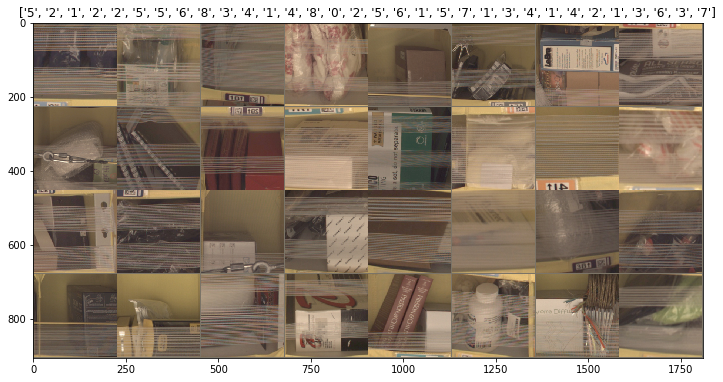

In [5]:
inputs, classes = next(iter(dset_loaders['train']))
out = torchvision.utils.make_grid(inputs,nrow=8)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
plt.figure(figsize=(12,12))
ft.imshow(out, title=[dset_classes[x] for x in classes])

## 2- Log Keeping

This section includes the functions defined for the log keeping. Since CNNs require lots of trials, I found it easy to record the properties of the each trial with their performances in an excel file. I also added tnesorboard summaries for every trial and individual text files for showing the details of the network.

Below code declares the required parameters for the network which will be also used inside log keeping

In [15]:
def make_coeff(n, metric, lmbda = 1):
    if metric is 'ccr':
        return [1]
    elif metric is 'ccr1':
        return [1, 1, 1]
    elif metric is 'mae':
        coeff = np.arange(1,n)/(n-1)
    elif metric is 'mse':
        coeff = np.zeros(n-1)
        coeff[0] = 2*n-3
        for k in range(1, n-1):
            coeff[k] = coeff[k-1] + 2*n - (2*(k+1)+1)
        coeff = coeff /((n-1)**2)
    else:
        print('Undefined Metric: ' + metric)
    coeff = np.concatenate((coeff, coeff[::-1][1:]), axis=0)
    coeff = coeff * lmbda
    coeff[n-2] = 1
    return coeff

In [3]:
def make_coeff(n, metric, loss='softmax', lmbda = 1):
    if metric is 'ccr':
        return np.eye(n)
    elif metric is 'ccr1':
        coeff = np.zeros((n,n))
        for k in range(n):
            coeff[k,np.maximum(k-1,0):np.minimum(k+2,n)]=1
        if loss is 'softmax':
            coeff_sum = np.sum(coeff,axis=1).reshape(-1,1)*np.ones((1,n))
            coeff = coeff/coeff_sum
    elif metric is 'mae':
        coeff = np.zeros((n,n))
        for k in range(n):
            alpha = 1/(n-1)
            row = np.zeros((1,n))
            for l in range(n-1):
                row_ = np.zeros((1,n))
                row_[0, np.maximum(k-l,0):np.minimum(k+l+1,n)] = 1
                if loss is 'softmax':
                    row_ = row_/np.sum(row_)
                row += row_*alpha
            coeff[k,:]=row
    elif metric is 'mse':
        coeff = np.zeros((n,n))
        for k in range(n):
            row = np.zeros((1,n))
            for l in range(n-1):
                row_ = np.zeros((1,n))
                row_[0, np.maximum(k-l,0):np.minimum(k+l+1,n)] = 1
                row += (2*l+1)*row_
                
            if loss is 'softmax':
                row = row / np.sum(row)
            elif loss is 'sigmoid':
                row = row / ((n**2)-(2*n)+1)
            else:
                 print('Undefined Loss: ' + str(loss))
            coeff[k,:]=row
    else:
        print('Undefined Metric: ' + metric)
        
    coeff = np.eye(n)*(1-lmbda) + lmbda*coeff
        
    #coeff = np.concatenate((coeff, coeff[::-1][1:]), axis=0)
    #coeff = coeff * lmbda
    #coeff[n-2] = 1
    return coeff

coeff = make_coeff(5,'mse',loss = 'sigmoid', lmbda=.5)
print(coeff)

[[1.      0.46875 0.375   0.21875 0.     ]
 [0.46875 1.      0.46875 0.375   0.21875]
 [0.375   0.46875 1.      0.46875 0.375  ]
 [0.21875 0.375   0.46875 1.      0.46875]
 [0.      0.21875 0.375   0.46875 1.     ]]


In [4]:
network='resnet18' #Initial network archtiecture.'loaded'forusing a saved network
networkName='resnet18_real_sgd_multisoft_August29  19:06:27' #Directory for the saved network
optimizer='sgd' #Optimizer function
iter_loc=15 #Number of the first column in the excel file for writing the results.
end_to_end=True #Booolean to decide whether to train the network end-to-end or not.
lr=0.01 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
pretrained=True 
mse_loss=False #Scalar MSE loss
nclasses=10 #Number of output classes
metric = 'ccr'
coeff_lmbda =  0
multi_coeff = make_coeff(nclasses, metric, loss = 'sigmoid', lmbda = coeff_lmbda)
KL = False #KL divergence for porbability measure

'''Multipliers for loss functions'''
single_loss=1.
multi_loss=0.

comment=' ' #Additional comments if any

Let us define the functions for creating a text file and adding networkproperties to an excel file. 

In [5]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs/'+logname+'/Network_properties.txt','w')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Random seed: '+str(random_seed)+'\n')
    f.write('Shuffle: '+str(shuffle)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Network: '+network+'\n')
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.write('Network is pretrained: '+str(pretrained)+'\n')
    f.write('Network laoded from: '+networkName+'\n')
    f.write('MSE loss function: '+str(mse_loss)+'\n')
    f.close()

In [6]:
import openpyxl
import time

def writeLog_xlsx(logname='logs.xlsx',iter_loc=15):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    multi_coeff = make_coeff(nclasses, metric, loss = 'sigmoid', lmbda = coeff_lmbda)
    if network=='loaded':
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),networkName,str(split),str(random_seed),str(shuffle),
               optimizer, crt, str(multi_coeff), str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    else:
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),network,str(split),str(random_seed),str(shuffle),
               optimizer, crt, str(multi_coeff),str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)

## 3 - Training and Validation

In this part we will define the functions for training a CNN with different properties and loss functions.

The following function takes bunch of properties defined in the beginning of Section-2 as input and creates network using those properties.

In [7]:
model_ft = models.resnet18(pretrained=pretrained)
#model_ft.layer1 = nn.Sequential()#model_ft.layer4
'''num_ftrs = model_ft.fc.in_features
model_ft.conv1 = nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=3,
                               bias=False)

model_ft.bn1 = nn.BatchNorm2d(128)
model_ft.avgpool = nn.AvgPool2d(2)
print(model_ft)
model_ft.fc = nn.Linear(num_ftrs, nclasses)'''


model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [7]:
def network_loader(comment=comment,
                    network=network,
                    networkName=networkName,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    end_to_end=end_to_end,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    pretrained=pretrained,
                    mse_loss=mse_loss,
                    nclasses=nclasses):
    
    '''Load the network from pytorch'''
    if(network=='resnet18'):
        model_ft = models.resnet18(pretrained=pretrained)
        '''' model_ft.conv1 = nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=3,
                               bias=False)

        model_ft.bn1 = nn.BatchNorm2d(128)
        model_ft.layer1 = nn.Sequential()
        model_ft.layer2 = nn.Sequential()
        model_ft.avgpool = nn.AvgPool2d(4)'''
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features #Change the last layer to adapt new classes
        if(mse_loss): #For MSE loss last layer should be a scalar
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet34'):
        model_ft = models.resnet34(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet50'):
        model_ft = models.resnet50(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='resnet101'):
        model_ft = models.resnet101(pretrained=pretrained)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        if(mse_loss):
            model_ft.fc = nn.Linear(num_ftrs, 1)
        else:    
            model_ft.fc = nn.Linear(num_ftrs, nclasses)
    elif(network=='alexnet'):
        model_ft = models.alexnet(pretrained=pretrained)
        num_ftrs = model_ft.classifier[6].out_features
        setattr(model_ft.classifier, '7', nn.ReLU(inplace=True))
        setattr(model_ft.classifier, '8', nn.Dropout())
        setattr(model_ft.classifier, '9', nn.Linear(num_ftrs,nclasses))

    elif(network=='loaded'):#Use the saved network when network='loaded'
        model_ft = torch.load('./saved_models/'+networkName)
        if not end_to_end:
            for param in model_ft.parameters():
                param.requires_grad = False 
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, nclasses)
    else:
        raise ValueError('Undefined network '+network)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

Now define a simple function to be able to run our training in a single line

In [8]:
def write_epochs(result_log, logname):
    print(len(result_log))

    wb_tr = openpyxl.Workbook()
    ws_tr = wb_tr.active
    wb_val = openpyxl.Workbook()
    ws_val = wb_val.active
    print(logname)

    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, nclasses))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, nclasses))

    prev_epoch = 0
    for result in result_log:
        epoch = result[1]
        if not epoch == prev_epoch:
            ws_tr.append(['Epoch ' + str(prev_epoch)])
            ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
            ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_tr[1:,:].T.tolist():
                ws_tr.append(probs)
            wb_tr.save('./runs/'+logname + '/train.xlsx')
            ws_val.append(['Epoch ' + str(prev_epoch)])
            ws_val.append(label_arr_val[1:].reshape(-1).tolist())
            ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_val[1:,:].T.tolist():
                ws_val.append(probs)
            wb_val.save('./runs/'+logname + '/val.xlsx')

            del label_arr_tr, label_arr_val, probs_arr_tr, probs_arr_val
            label_arr_tr = np.zeros((1,1))
            probs_arr_tr = np.zeros((1, nclasses))
            label_arr_val = np.zeros((1,1))
            probs_arr_val = np.zeros((1, nclasses))
            prev_epoch = epoch

        label = np.asarray(result[2]).reshape(-1,1)
        scores = np.asarray(result[3])
        exp_scores = np.exp(scores - np.max(scores,axis=1).reshape(-1, 1)*np.ones(nclasses))
        probs = np.round(exp_scores/(np.sum(exp_scores,axis=1).reshape(-1, 1)*np.ones(nclasses)), decimals=2)
        if result[0] == 'train':
            label_arr_tr  =np.append(label_arr_tr, label)
            probs_arr_tr = np.append(probs_arr_tr, probs, axis=0)
        elif result[0] == 'val':
            label_arr_val  =np.append(label_arr_val, label)
            probs_arr_val = np.append(probs_arr_val, probs, axis=0)



    ws_tr.append(['Epoch ' + str(epoch)])
    ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
    ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_tr[1:,:].T.tolist():
        ws_tr.append(probs)
    wb_tr.save('./runs/'+logname + '/train.xlsx')
    ws_val.append(['Epoch ' + str(epoch)])
    ws_val.append(label_arr_val[1:].reshape(-1).tolist())
    ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_val[1:,:].T.tolist():
        ws_val.append(probs)
    wb_val.save('./runs/'+logname + '/val.xlsx')
    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, nclasses))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, nclasses))
    prev_epoch = epoch
    print('Finito')

In [9]:
importlib.reload(ft)

def run_network():
    print(iter_loc)
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            network=network,
                                            networkName=networkName,
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            end_to_end=end_to_end,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            pretrained=pretrained,
                                            mse_loss=mse_loss,
                                            nclasses=nclasses)
    
    multi_coeff = make_coeff(nclasses, metric, loss = 'sigmoid', lmbda = coeff_lmbda)
    print('Multi coeff is ' + str(multi_coeff))
    '''Name of the trial'''
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname=network+'_'+'_'+optimizer+'_'+crt+'_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    best_model, last_model, result_log = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_log=500,
                            lr_decay_epoch=lr_decay_epoch,init_lr=lr,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=nclasses,
                            multi_coeff = multi_coeff, single_coeff = multi_coeff, KL = KL, write_log = True)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/'+logname+'_best')
    torch.save(last_model,'./saved_models/'+logname+'_last')
    
    print('Writing results')
    #write_epochs(result_log, logname)
    print('Wrote results')
    '''Free up the memory'''
    del model_ft, result_log
    


## 4 - Trials

The loss function we used in the experiments is the following,

$$loss(\mathbf{y},\hat{y})=(1-\lambda )loss_{single}(\mathbf{y},\hat{y})+\lambda loss_{multi}(\mathbf{y},\hat{y})$$
where $\mathbf{y}$ is the ground truth and $\hat{y}$ is the prediction.

Now lets test our function for different values of $\lambda$.

In [ ]:
lr=0.01 #Initial learning rate
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=20 #Number of epoch for learning rate decay
single_loss=0.0
multi_loss=1.0
coeff_lmbda = 1

metric = 'mse'  
run_network()

metric = 'mae'  
run_network()

metric = 'ccr'  
run_network()

metric = 'ccr1'  
run_network()
    


15
Multi coeff is [[1.         0.98765432 0.95061728 0.88888889 0.80246914 0.69135802
  0.55555556 0.39506173 0.20987654 0.        ]
 [0.98765432 1.         0.98765432 0.95061728 0.88888889 0.80246914
  0.69135802 0.55555556 0.39506173 0.20987654]
 [0.95061728 0.98765432 1.         0.98765432 0.95061728 0.88888889
  0.80246914 0.69135802 0.55555556 0.39506173]
 [0.88888889 0.95061728 0.98765432 1.         0.98765432 0.95061728
  0.88888889 0.80246914 0.69135802 0.55555556]
 [0.80246914 0.88888889 0.95061728 0.98765432 1.         0.98765432
  0.95061728 0.88888889 0.80246914 0.69135802]
 [0.69135802 0.80246914 0.88888889 0.95061728 0.98765432 1.
  0.98765432 0.95061728 0.88888889 0.80246914]
 [0.55555556 0.69135802 0.80246914 0.88888889 0.95061728 0.98765432
  1.         0.98765432 0.95061728 0.88888889]
 [0.39506173 0.55555556 0.69135802 0.80246914 0.88888889 0.95061728
  0.98765432 1.         0.98765432 0.95061728]
 [0.20987654 0.39506173 0.55555556 0.69135802 0.80246914 0.88888889
  

500/3125, acc: 0.2917, CIR-1: 0.7468, RMSE: 1.4505, MAE: 1.0693
1000/3125, acc: 0.2918, CIR-1: 0.7481, RMSE: 1.4491, MAE: 1.0696
1500/3125, acc: 0.2918, CIR-1: 0.7468, RMSE: 1.4511, MAE: 1.0716
2000/3125, acc: 0.2926, CIR-1: 0.7478, RMSE: 1.4515, MAE: 1.0708
2500/3125, acc: 0.2933, CIR-1: 0.7478, RMSE: 1.4538, MAE: 1.0715
3000/3125, acc: 0.2940, CIR-1: 0.7479, RMSE: 1.4544, MAE: 1.0713
Epoch is 11
Epoch loss is 0.011332235550880433
train Loss: 11.3322 Acc: 0.2943 CIR-1: 0.7480 RMSE 1.4556 MAE 1.0719
Epoch is 11
Epoch loss is 0.011469495794177055
val Loss: 11.4695 Acc: 0.2790 CIR-1: 0.7251 RMSE 1.5106 MAE 1.1242

Epoch 12/49
----------
500/3125, acc: 0.3011, CIR-1: 0.7488, RMSE: 1.4419, MAE: 1.0573
1000/3125, acc: 0.2975, CIR-1: 0.7530, RMSE: 1.4305, MAE: 1.0541
1500/3125, acc: 0.2960, CIR-1: 0.7514, RMSE: 1.4336, MAE: 1.0580
2000/3125, acc: 0.2972, CIR-1: 0.7520, RMSE: 1.4345, MAE: 1.0570
2500/3125, acc: 0.2970, CIR-1: 0.7515, RMSE: 1.4377, MAE: 1.0591
3000/3125, acc: 0.2964, CIR-1: 0.

Epoch is 23
Epoch loss is 0.011516846194863319
val Loss: 11.5168 Acc: 0.3022 CIR-1: 0.7424 RMSE 1.4993 MAE 1.0893

Epoch 24/49
----------
500/3125, acc: 0.3417, CIR-1: 0.8062, RMSE: 1.2436, MAE: 0.9045
1000/3125, acc: 0.3423, CIR-1: 0.8092, RMSE: 1.2421, MAE: 0.9032
1500/3125, acc: 0.3439, CIR-1: 0.8103, RMSE: 1.2435, MAE: 0.9024
2000/3125, acc: 0.3424, CIR-1: 0.8103, RMSE: 1.2440, MAE: 0.9042
2500/3125, acc: 0.3420, CIR-1: 0.8105, RMSE: 1.2456, MAE: 0.9052
3000/3125, acc: 0.3408, CIR-1: 0.8101, RMSE: 1.2472, MAE: 0.9072
Epoch is 24
Epoch loss is 0.01093582254499197
train Loss: 10.9358 Acc: 0.3407 CIR-1: 0.8102 RMSE 1.2478 MAE 0.9080
Epoch is 24
Epoch loss is 0.011523315301537513
val Loss: 11.5233 Acc: 0.3113 CIR-1: 0.7462 RMSE 1.5076 MAE 1.0823

Epoch 25/49
----------
500/3125, acc: 0.3372, CIR-1: 0.8106, RMSE: 1.2456, MAE: 0.9072
1000/3125, acc: 0.3410, CIR-1: 0.8115, RMSE: 1.2438, MAE: 0.9045
1500/3125, acc: 0.3421, CIR-1: 0.8110, RMSE: 1.2439, MAE: 0.9042
2000/3125, acc: 0.3418, CI

Epoch is 36
Epoch loss is 0.010863030988872051
train Loss: 10.8630 Acc: 0.3527 CIR-1: 0.8245 RMSE 1.2027 MAE 0.8724
Epoch is 36
Epoch loss is 0.011567969238758087
val Loss: 11.5680 Acc: 0.3051 CIR-1: 0.7409 RMSE 1.5167 MAE 1.0956

Epoch 37/49
----------
500/3125, acc: 0.3559, CIR-1: 0.8225, RMSE: 1.1988, MAE: 0.8659
1000/3125, acc: 0.3538, CIR-1: 0.8236, RMSE: 1.2003, MAE: 0.8692
1500/3125, acc: 0.3559, CIR-1: 0.8245, RMSE: 1.1977, MAE: 0.8663
2000/3125, acc: 0.3544, CIR-1: 0.8251, RMSE: 1.1993, MAE: 0.8683
2500/3125, acc: 0.3535, CIR-1: 0.8251, RMSE: 1.2023, MAE: 0.8703
3000/3125, acc: 0.3525, CIR-1: 0.8248, RMSE: 1.2029, MAE: 0.8717
Epoch is 37
Epoch loss is 0.010859398976564407
train Loss: 10.8594 Acc: 0.3521 CIR-1: 0.8254 RMSE 1.2026 MAE 0.8721
Epoch is 37
Epoch loss is 0.011554311907291412
val Loss: 11.5543 Acc: 0.3172 CIR-1: 0.7496 RMSE 1.5213 MAE 1.0815

Epoch 38/49
----------
500/3125, acc: 0.3477, CIR-1: 0.8229, RMSE: 1.2055, MAE: 0.8757
1000/3125, acc: 0.3502, CIR-1: 0.8231, 

2000/3125, acc: 0.3568, CIR-1: 0.8317, RMSE: 1.1790, MAE: 0.8549
2500/3125, acc: 0.3565, CIR-1: 0.8306, RMSE: 1.1825, MAE: 0.8572
3000/3125, acc: 0.3576, CIR-1: 0.8302, RMSE: 1.1828, MAE: 0.8567
Epoch is 49
Epoch loss is 0.010820328807532788
train Loss: 10.8203 Acc: 0.3579 CIR-1: 0.8309 RMSE 1.1821 MAE 0.8563
Epoch is 49
Epoch loss is 0.011572215661406517
val Loss: 11.5722 Acc: 0.3084 CIR-1: 0.7411 RMSE 1.5201 MAE 1.0937

Training complete in 294m 3s
Best val RMSE: 1.489094
Writing results
Wrote results
15
Multi coeff is [[1.         0.88888889 0.77777778 0.66666667 0.55555556 0.44444444
  0.33333333 0.22222222 0.11111111 0.        ]
 [0.88888889 1.         0.88888889 0.77777778 0.66666667 0.55555556
  0.44444444 0.33333333 0.22222222 0.11111111]
 [0.77777778 0.88888889 1.         0.88888889 0.77777778 0.66666667
  0.55555556 0.44444444 0.33333333 0.22222222]
 [0.66666667 0.77777778 0.88888889 1.         0.88888889 0.77777778
  0.66666667 0.55555556 0.44444444 0.33333333]
 [0.55555556 

1500/3125, acc: 0.3376, CIR-1: 0.7523, RMSE: 1.4801, MAE: 1.0425
2000/3125, acc: 0.3380, CIR-1: 0.7535, RMSE: 1.4808, MAE: 1.0419
2500/3125, acc: 0.3388, CIR-1: 0.7538, RMSE: 1.4792, MAE: 1.0403
3000/3125, acc: 0.3392, CIR-1: 0.7544, RMSE: 1.4789, MAE: 1.0396
Epoch is 10
Epoch loss is 0.017345392476320266
train Loss: 17.3454 Acc: 0.3387 CIR-1: 0.7541 RMSE 1.4811 MAE 1.0415
Epoch is 10
Epoch loss is 0.017447211617231367
val Loss: 17.4472 Acc: 0.3406 CIR-1: 0.7469 RMSE 1.5242 MAE 1.0634

Epoch 11/49
----------
500/3125, acc: 0.3406, CIR-1: 0.7595, RMSE: 1.4528, MAE: 1.0209
1000/3125, acc: 0.3437, CIR-1: 0.7614, RMSE: 1.4528, MAE: 1.0185
1500/3125, acc: 0.3459, CIR-1: 0.7614, RMSE: 1.4563, MAE: 1.0187
2000/3125, acc: 0.3452, CIR-1: 0.7608, RMSE: 1.4583, MAE: 1.0205
2500/3125, acc: 0.3444, CIR-1: 0.7611, RMSE: 1.4589, MAE: 1.0215
3000/3125, acc: 0.3431, CIR-1: 0.7608, RMSE: 1.4627, MAE: 1.0246
Epoch is 11
Epoch loss is 0.017307621530890466
train Loss: 17.3076 Acc: 0.3434 CIR-1: 0.7613 RMSE

500/3125, acc: 0.3924, CIR-1: 0.8177, RMSE: 1.2473, MAE: 0.8576
1000/3125, acc: 0.3949, CIR-1: 0.8195, RMSE: 1.2491, MAE: 0.8565
1500/3125, acc: 0.3967, CIR-1: 0.8194, RMSE: 1.2501, MAE: 0.8558
2000/3125, acc: 0.3970, CIR-1: 0.8201, RMSE: 1.2503, MAE: 0.8552
2500/3125, acc: 0.3972, CIR-1: 0.8201, RMSE: 1.2535, MAE: 0.8565
3000/3125, acc: 0.3967, CIR-1: 0.8212, RMSE: 1.2523, MAE: 0.8559
Epoch is 23
Epoch loss is 0.01692310808181763
train Loss: 16.9231 Acc: 0.3971 CIR-1: 0.8214 RMSE 1.2520 MAE 0.8559
Epoch is 23
Epoch loss is 0.017462016916275025
val Loss: 17.4620 Acc: 0.3555 CIR-1: 0.7477 RMSE 1.5252 MAE 1.0521

Epoch 24/49
----------
500/3125, acc: 0.3924, CIR-1: 0.8237, RMSE: 1.2434, MAE: 0.8522
1000/3125, acc: 0.3947, CIR-1: 0.8237, RMSE: 1.2470, MAE: 0.8529
1500/3125, acc: 0.3982, CIR-1: 0.8241, RMSE: 1.2476, MAE: 0.8503
2000/3125, acc: 0.3990, CIR-1: 0.8247, RMSE: 1.2450, MAE: 0.8485
2500/3125, acc: 0.3979, CIR-1: 0.8237, RMSE: 1.2459, MAE: 0.8507
3000/3125, acc: 0.3976, CIR-1: 0.8

Epoch is 35
Epoch loss is 0.01749543433189392
val Loss: 17.4954 Acc: 0.3465 CIR-1: 0.7469 RMSE 1.5286 MAE 1.0622

Epoch 36/49
----------
500/3125, acc: 0.4128, CIR-1: 0.8347, RMSE: 1.1997, MAE: 0.8115
1000/3125, acc: 0.4108, CIR-1: 0.8352, RMSE: 1.2061, MAE: 0.8170
1500/3125, acc: 0.4110, CIR-1: 0.8363, RMSE: 1.1998, MAE: 0.8142
2000/3125, acc: 0.4133, CIR-1: 0.8365, RMSE: 1.1994, MAE: 0.8123


In [ ]:
for k in range(5):
    metric = 'ccr'
    KL = True
    single_loss=1.
    multi_loss=0.
    run_network()

In [ ]:
KL = True

metric = 'ccr'
single_loss= 1.0
multi_loss = 0.0
run_network()

metric = 'ccr1'
run_network()

metric = 'mae'
run_network()

metric = 'mse'
run_network()

metric = 'ccr1'
for lmbda in [.2, .4, .6, .8, .9]:
    single_loss= round(1.-lmbda, 1)
    multi_loss = lmbda
    print('Single loss = '+str(single_loss)+', Multi loss = '+str(multi_loss))
    run_network()
    
metric = 'mae'
for lmbda in [.2, .4, .6, .8, .9]:
    single_loss= round(1.-lmbda, 1)
    multi_loss = lmbda
    print('Single loss = '+str(single_loss)+', Multi loss = '+str(multi_loss))
    run_network()

    

In [ ]:
slr=0.01 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
single_loss= 1.0
multi_loss = 0.0
metric = 'ccr'
run_network()
metric = 'ccr1'
run_network()
metric = 'mae'
run_network()
metric = 'mse'
run_network()

In [ ]:
single_loss=0.
multi_loss=1.

for k in range(len(dset_loaders_arr)):
    dset_loaders = dset_loaders_arr[k]
    run_network()
    
single_loss=.1
multi_loss=.9

for k in range(len(dset_loaders_arr)):
    dset_loaders = dset_loaders_arr[k]
    run_network()

In [ ]:
multi_coeff = (1/5) * [1, 2, 3, 4, 5, 4, 3, 2, 1]
run_network()

In [ ]:
multi_coeff = np.asarray([1])
print(multi_coeff)
run_network()

single_loss=1.
multi_loss=0.
run_network()

single_loss = 0.1
multi_loss = 0.9
multi_coeff = [1, 1, 1]
run_network()

In [ ]:
'''multi_coeff = (1/5) * np.asarray([1, 2, 3, 4, 5, 4, 3, 2, 1])
print(multi_coeff)
run_network()'''

multi_coeff = (1/25) * np.asarray([9, 16, 21, 24, 25, 24, 21, 16, 9])
print(multi_coeff)
run_network()

multi_coeff = np.asarray([1])
print(multi_coeff)
run_network()

single_loss=1.
multi_loss=0.
run_network()

In [ ]:
single_loss = 0.1
multi_loss = 0.9
multi_coeff = (1/5) * np.asarray([1, 2, 3, 4, 5, 4, 3, 2, 1])
print(multi_coeff)
run_network()

In [ ]:
single_loss = 0.0
multi_loss = 1.0
multi_coeff =  np.asarray([.9, 1, .9])
print(multi_coeff)
run_network()

In [ ]:
multi_coeff = (1/25) * np.asarray([9, 16, 21, 24, 25, 24, 21, 16, 9])
extend = int((len(multi_coeff) - 1) / 2)
label_multi = np.zeros(numOut + 2 * extend)
label_multi[label:label + 2 * extend + 1] = multi_coeff

if extend is not 0:
    label_multi = label_multi[extend:-extend]

print(label_multi)

In [ ]:
mse_loss=False
for lmbda in [1., 1., 1., 1., 1.]:
    single_loss= round(1.-lmbda, 1)
    multi_loss = lmbda
    print('Single loss = '+str(single_loss)+', Multi loss = '+str(multi_loss))
    run_network()